# Model Training and Evaluation

This notebook covers the training and evaluation of transformer-based multi-label text classification models for Sri Lankan tourist review analysis.

## Overview
- **Objective**: Multi-label classification of tourist reviews into experiential dimensions
- **Models**: BERT and RoBERTa transformer models
- **Labels**: 4 experiential dimensions (Regenerative & Eco-Tourism, Integrated Wellness, Immersive Culinary, Off-the-Beaten-Path Adventure)
- **Framework**: PyTorch with MLflow experiment tracking


## 1. Setup and Data Loading


In [2]:
%pip install mlflow

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.7/26.7 MB 99.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 95.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 67.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 16.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 314.0/314.0 kB 25.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 717.5/717.5 kB 48.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.6/106.6 kB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.4/96.4 kB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72

In [3]:
%pip install databricks-sdk

In [4]:
# Import required libraries
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from torch.utils.data import DataLoader, Dataset, random_split
from transformers import (
    BertForSequenceClassification,
    RobertaForSequenceClassification,
    AutoTokenizer,
    get_linear_schedule_with_warmup
)
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    confusion_matrix, multilabel_confusion_matrix, classification_report
)
import mlflow
import mlflow.pytorch
from mlflow.models import infer_signature
import json
import os
import warnings
from dotenv import load_dotenv

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)

print("Libraries imported successfully")
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
if torch.cuda.is_available():
    print(f"CUDA device: {torch.cuda.get_device_name(0)}")


Libraries imported successfully
PyTorch version: 2.8.0+cu126
CUDA available: True
CUDA device: NVIDIA A100-SXM4-80GB


In [5]:
# Load environment variables
load_dotenv()

# Google Colab integration (if running in Colab)
try:
    from google.colab import drive, userdata
    drive.mount('/content/drive')
    DATABRICKS_HOST = userdata.get("DATABRICKS_HOST")
    DATABRICKS_TOKEN = userdata.get("DATABRICKS_TOKEN")
    print("Google Colab environment detected")
except ImportError:
    # Local environment
    DATABRICKS_HOST = os.getenv("DATABRICKS_HOST")
    DATABRICKS_TOKEN = os.getenv("DATABRICKS_TOKEN")
    print("Local environment detected")

# MLflow setup
if DATABRICKS_HOST and DATABRICKS_TOKEN:
    os.environ["DATABRICKS_HOST"] = DATABRICKS_HOST
    os.environ["DATABRICKS_TOKEN"] = DATABRICKS_TOKEN
    mlflow.set_tracking_uri("databricks")
    mlflow.set_experiment("/Users/j2damax@gmail.com/serendip-travel-review-classifier-experiments")
    print("MLflow configured with Databricks")
else:
    mlflow.set_tracking_uri("file:./mlruns")
    mlflow.set_experiment("serendip-travel-experiments")
    print("MLflow configured with local tracking")


Mounted at /content/drive
Google Colab environment detected
MLflow configured with Databricks


In [6]:
# Define dataset class
class ReviewsDataset(Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = torch.tensor(labels, dtype=torch.float32)

    def __getitem__(self, idx):
        item = {key: val[idx] for key, val in self.encodings.items()}
        item['labels'] = self.labels[idx]
        return item

    def __len__(self):
        return len(self.labels)

# Load datasets
try:

    train_data = torch.load('/content/drive/MyDrive/SerendipTravel/data/processed/train_dataset.pt', weights_only=False)
    test_data = torch.load('/content/drive/MyDrive/SerendipTravel/data/processed/test_dataset.pt', weights_only=False)

    train_dataset = ReviewsDataset(train_data['encodings'], train_data['labels'])
    test_dataset = ReviewsDataset(test_data['encodings'], test_data['labels'])

    num_labels = train_data['labels'].shape[1]
    print(f"Dataset loaded successfully:")
    print(f"  Training samples: {len(train_dataset)}")
    print(f"  Test samples: {len(test_dataset)}")
    print(f"  Number of labels: {num_labels}")
    print(f"  Label shape: {train_data['labels'].shape}")

except FileNotFoundError as e:
    print(f"Error: Dataset files not found. {e}")
    print("Please ensure the processed datasets are available in '../data/processed/'")
    raise
except Exception as e:
    print(f"Error loading datasets: {e}")
    raise


Dataset loaded successfully:
  Training samples: 12924
  Test samples: 3232
  Number of labels: 4
  Label shape: (12924, 4)


## 2. Model Training Function


In [13]:
def train_and_evaluate_model(
    model_name="bert-base-uncased",
    epochs=3,
    batch_size=16,
    learning_rate=2e-5,
    train_dataset=None,
    test_dataset=None,
    num_labels=None,
    experiment_name="model-experiment",
    validation_split=0.1
):
    """
    Train and evaluate a transformer model for multi-label classification.

    Returns:
        dict: Training history and final predictions
    """
    # Split training data for validation
    train_size = int((1 - validation_split) * len(train_dataset))
    val_size = len(train_dataset) - train_size
    train_subset, val_subset = random_split(train_dataset, [train_size, val_size])

    # Model selection
    if model_name.startswith("roberta"):
        model_cls = RobertaForSequenceClassification
    else:
        model_cls = BertForSequenceClassification

    model = model_cls.from_pretrained(
        model_name,
        num_labels=num_labels,
        problem_type='multi_label_classification'
    )

    # Data loaders
    train_loader = DataLoader(train_subset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_subset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Optimizer and scheduler
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=0, num_training_steps=total_steps
    )

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    # Training history
    history = {
        'train_loss': [],
        'val_loss': [],
        'val_accuracy': [],
        'val_f1': []
    }

    with mlflow.start_run(run_name=experiment_name):
        # Log parameters
        mlflow.log_param("model_name", model_name)
        mlflow.log_param("epochs", epochs)
        mlflow.log_param("batch_size", batch_size)
        mlflow.log_param("learning_rate", learning_rate)

        # Training loop
        for epoch in range(epochs):
            # Training phase
            model.train()
            total_train_loss = 0

            for batch in train_loader:
                optimizer.zero_grad()
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].to(device)

                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()
                scheduler.step()
                total_train_loss += loss.item()

            avg_train_loss = total_train_loss / len(train_loader)

            # Validation phase
            model.eval()
            total_val_loss = 0
            all_val_preds = []
            all_val_labels = []

            with torch.no_grad():
                for batch in val_loader:
                    input_ids = batch['input_ids'].to(device)
                    attention_mask = batch['attention_mask'].to(device)
                    labels = batch['labels'].to(device)

                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    val_loss = outputs.loss
                    total_val_loss += val_loss.item()

                    logits = outputs.logits.cpu().numpy()
                    preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()
                    all_val_preds.append(preds)
                    all_val_labels.append(labels.cpu().numpy())

            avg_val_loss = total_val_loss / len(val_loader)
            all_val_preds = np.vstack(all_val_preds)
            all_val_labels = np.vstack(all_val_labels)

            val_accuracy = accuracy_score(all_val_labels, all_val_preds)
            val_f1 = f1_score(all_val_labels, all_val_preds, average='macro')

            # Store history
            history['train_loss'].append(avg_train_loss)
            history['val_loss'].append(avg_val_loss)
            history['val_accuracy'].append(val_accuracy)
            history['val_f1'].append(val_f1)

            print(f"Epoch {epoch+1}/{epochs}: Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Val F1: {val_f1:.4f}")

            # Log metrics
            mlflow.log_metric("train_loss", avg_train_loss, step=epoch)
            mlflow.log_metric("val_loss", avg_val_loss, step=epoch)
            mlflow.log_metric("val_accuracy", val_accuracy, step=epoch)
            mlflow.log_metric("val_f1", val_f1, step=epoch)

        # Final test evaluation
        model.eval()
        all_test_preds = []
        all_test_labels = []

        with torch.no_grad():
            for batch in test_loader:
                input_ids = batch['input_ids'].to(device)
                attention_mask = batch['attention_mask'].to(device)
                labels = batch['labels'].cpu().numpy()

                outputs = model(input_ids=input_ids, attention_mask=attention_mask)
                logits = outputs.logits.cpu().numpy()
                preds = (torch.sigmoid(torch.tensor(logits)) > 0.5).int().numpy()
                all_test_preds.append(preds)
                all_test_labels.append(labels)

        all_test_preds = np.vstack(all_test_preds)
        all_test_labels = np.vstack(all_test_labels)

        # Calculate final metrics
        test_accuracy = accuracy_score(all_test_labels, all_test_preds)
        test_f1 = f1_score(all_test_labels, all_test_preds, average='macro')
        test_precision = precision_score(all_test_labels, all_test_preds, average='macro', zero_division=0)
        test_recall = recall_score(all_test_labels, all_test_preds, average='macro', zero_division=0)

        # Calculate per-label metrics
        f1_scores = [f1_score(all_test_labels[:, i], all_test_preds[:, i], zero_division=0) for i in range(num_labels)]
        precision_scores = [precision_score(all_test_labels[:, i], all_test_preds[:, i], zero_division=0) for i in range(num_labels)]
        recall_scores = [recall_score(all_test_labels[:, i], all_test_preds[:, i], zero_division=0) for i in range(num_labels)]

        print(f"\nFinal Test Results:")
        print(f"Accuracy: {test_accuracy:.4f}")
        print(f"F1-Score: {test_f1:.4f}")
        print(f"Precision: {test_precision:.4f}")
        print(f"Recall: {test_recall:.4f}")

        # Log final metrics
        mlflow.log_metric("test_accuracy", test_accuracy)
        mlflow.log_metric("test_f1", test_f1)
        mlflow.log_metric("test_precision", test_precision)
        mlflow.log_metric("test_recall", test_recall)

        # Log per-label metrics
        for i, (f1, p, r) in enumerate(zip(f1_scores, precision_scores, recall_scores)):
            mlflow.log_metric(f"f1_label_{i}", f1)
            mlflow.log_metric(f"precision_label_{i}", p)
            mlflow.log_metric(f"recall_label_{i}", r)

        # Generate and save classification report
        report = classification_report(all_test_labels, all_test_preds, output_dict=True, zero_division=0)
        with open("classification_report.json", "w") as f:
            json.dump(report, f, indent=2)
        mlflow.log_artifact("classification_report.json")

        # Save model
        example_batch = next(iter(test_loader))
        inputs = {
            "input_ids": example_batch["input_ids"][:1].cpu().numpy(),
            "attention_mask": example_batch["attention_mask"][:1].cpu().numpy()
        }
        outputs = model(
            input_ids=example_batch["input_ids"][:1].to(device),
            attention_mask=example_batch["attention_mask"][:1].to(device)
        ).logits.cpu().detach().numpy()

        signature = infer_signature(inputs, outputs)
        # mlflow.pytorch.log_model(model, "model", signature=signature)

        mlflow.pytorch.log_model(
            model,
            name="model",
            signature=signature
        )

        # Save predictions
        np.save("test_predictions.npy", all_test_preds)
        mlflow.log_artifact("test_predictions.npy")

    return {
        'history': history,
        'test_predictions': all_test_preds,
        'test_labels': all_test_labels,
        'model': model,
        'metrics': {
            'accuracy': test_accuracy,
            'f1': test_f1,
            'precision': test_precision,
            'recall': test_recall
        }
    }


## 3. Model Training Experiments


In [15]:
# Define label names
label_names = [
    'Regenerative & Eco-Tourism',
    'Integrated Wellness',
    'Immersive Culinary',
    'Off-the-Beaten-Path Adventure'
]

# Training configurations
configs = [
    {'model': 'bert-base-uncased', 'lr': 2e-5, 'bs': 8},
    {'model': 'bert-base-uncased', 'lr': 2e-5, 'bs': 16},
    {'model': 'roberta-base', 'lr': 2e-5, 'bs': 8},
    {'model': 'roberta-base', 'lr': 2e-5, 'bs': 16}
]

results = []

for config in configs:
    print(f"Training {config['model']} with lr={config['lr']}, bs={config['bs']}")
    print("-" * 50)

    result = train_and_evaluate_model(
        model_name=config['model'],
        epochs=5,
        batch_size=config['bs'],
        learning_rate=config['lr'],
        train_dataset=train_dataset,
        test_dataset=test_dataset,
        num_labels=num_labels,
        experiment_name=f"{config['model']}-lr{config['lr']}-bs{config['bs']}"
    )

    result['config'] = config
    results.append(result)

print("All experiments completed")

# Save results to a file
import pickle

try:
    with open('experiment_results.pkl', 'wb') as f:
        pickle.dump(results, f)
    print("Experiment results saved to 'experiment_results.pkl'")
except Exception as e:
    print(f"Error saving results: {e}")


Training bert-base-uncased with lr=2e-05, bs=8
--------------------------------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5: Train Loss: 0.2252, Val Loss: 0.1045, Val F1: 0.8935
Epoch 2/5: Train Loss: 0.0857, Val Loss: 0.0815, Val F1: 0.9229
Epoch 3/5: Train Loss: 0.0621, Val Loss: 0.0803, Val F1: 0.9289
Epoch 4/5: Train Loss: 0.0416, Val Loss: 0.0863, Val F1: 0.9227
Epoch 5/5: Train Loss: 0.0251, Val Loss: 0.0863, Val F1: 0.9221

Final Test Results:
Accuracy: 0.9233
F1-Score: 0.9250
Precision: 0.9681
Recall: 0.8859


2025/09/24 15:42:09 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/24 15:42:23 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.23.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


🏃 View run bert-base-uncased-lr2e-05-bs8 at: https://dbc-cfeb31c8-2841.cloud.databricks.com/ml/experiments/3866477269740015/runs/ff204ab808384e77a8b1e40f56a3fd2a
🧪 View experiment at: https://dbc-cfeb31c8-2841.cloud.databricks.com/ml/experiments/3866477269740015
Training bert-base-uncased with lr=2e-05, bs=16
--------------------------------------------------


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5: Train Loss: 0.2433, Val Loss: 0.1150, Val F1: 0.8870
Epoch 2/5: Train Loss: 0.0933, Val Loss: 0.0836, Val F1: 0.9242
Epoch 3/5: Train Loss: 0.0672, Val Loss: 0.0823, Val F1: 0.9172
Epoch 4/5: Train Loss: 0.0495, Val Loss: 0.0843, Val F1: 0.9212
Epoch 5/5: Train Loss: 0.0345, Val Loss: 0.0890, Val F1: 0.9177

Final Test Results:
Accuracy: 0.9158
F1-Score: 0.9225
Precision: 0.9551
Recall: 0.8930


2025/09/24 15:48:35 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/24 15:48:50 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.23.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


🏃 View run bert-base-uncased-lr2e-05-bs16 at: https://dbc-cfeb31c8-2841.cloud.databricks.com/ml/experiments/3866477269740015/runs/622c889c658f4022b71f99850471b418
🧪 View experiment at: https://dbc-cfeb31c8-2841.cloud.databricks.com/ml/experiments/3866477269740015
Training roberta-base with lr=2e-05, bs=8
--------------------------------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5: Train Loss: 0.4257, Val Loss: 0.3815, Val F1: 0.2207
Epoch 2/5: Train Loss: 0.2988, Val Loss: 0.1839, Val F1: 0.7722
Epoch 3/5: Train Loss: 0.1715, Val Loss: 0.1486, Val F1: 0.8493
Epoch 4/5: Train Loss: 0.1405, Val Loss: 0.1266, Val F1: 0.8740
Epoch 5/5: Train Loss: 0.1220, Val Loss: 0.1267, Val F1: 0.8704

Final Test Results:
Accuracy: 0.8561
F1-Score: 0.8525
Precision: 0.9634
Recall: 0.7680


2025/09/24 15:56:03 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/24 15:56:17 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.23.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


🏃 View run roberta-base-lr2e-05-bs8 at: https://dbc-cfeb31c8-2841.cloud.databricks.com/ml/experiments/3866477269740015/runs/505b5e1b2ac140b6813b2bf36132080e
🧪 View experiment at: https://dbc-cfeb31c8-2841.cloud.databricks.com/ml/experiments/3866477269740015
Training roberta-base with lr=2e-05, bs=16
--------------------------------------------------


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5: Train Loss: 0.4229, Val Loss: 0.3883, Val F1: 0.2759
Epoch 2/5: Train Loss: 0.2776, Val Loss: 0.1912, Val F1: 0.7933
Epoch 3/5: Train Loss: 0.1666, Val Loss: 0.1599, Val F1: 0.8445
Epoch 4/5: Train Loss: 0.1385, Val Loss: 0.1384, Val F1: 0.8707
Epoch 5/5: Train Loss: 0.1192, Val Loss: 0.1380, Val F1: 0.8722

Final Test Results:
Accuracy: 0.8601
F1-Score: 0.8598
Precision: 0.9617
Recall: 0.7807


2025/09/24 16:02:41 WARNING mlflow.utils.requirements_utils: Found torch version (2.8.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torch==2.8.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.
2025/09/24 16:02:57 WARNING mlflow.utils.requirements_utils: Found torchvision version (0.23.0+cu126) contains a local version label (+cu126). MLflow logged a pip requirement for this package as 'torchvision==0.23.0' without the local version label to make it installable from PyPI. To specify pip requirements containing local version labels, please use `conda_env` or `pip_requirements`.


🏃 View run roberta-base-lr2e-05-bs16 at: https://dbc-cfeb31c8-2841.cloud.databricks.com/ml/experiments/3866477269740015/runs/6a1aa00342924e4e98fe401aa59f435f
🧪 View experiment at: https://dbc-cfeb31c8-2841.cloud.databricks.com/ml/experiments/3866477269740015
All experiments completed
Experiment results saved to 'experiment_results.pkl'


## 4. Results Analysis


In [16]:
# Load results from file if available, otherwise assume they are in memory
import pickle
import os

results_file = 'experiment_results.pkl'

if 'results' not in locals() and os.path.exists(results_file):
    try:
        with open(results_file, 'rb') as f:
            results = pickle.load(f)
        print(f"Experiment results loaded from '{results_file}'")
    except Exception as e:
        print(f"Error loading results from '{results_file}': {e}")
        print("Please ensure the training cell (e2d22e92) has been run successfully.")
        results = None # Ensure results is None if loading fails
elif 'results' not in locals():
     print("Experiment results not found in memory. Please run the training cell (e2d22e92) first.")
     results = None


if results is not None:
    # Find best model
    best_result = max(results, key=lambda x: x['metrics']['f1'])
    print(f"Best model: {best_result['config']['model']} with F1-Score: {best_result['metrics']['f1']:.4f}")

    # Create results summary
    results_df = pd.DataFrame([
        {
            'Model': r['config']['model'],
            'Learning Rate': r['config']['lr'],
            'Batch Size': r['config']['bs'],
            'Test Accuracy': r['metrics']['accuracy'],
            'Test F1': r['metrics']['f1'],
            'Test Precision': r['metrics']['precision'],
            'Test Recall': r['metrics']['recall']
        }
        for r in results
    ])

    print("Results Summary:")
    print(results_df.round(4))
else:
    print("Cannot perform results analysis as 'results' is not available.")

Best model: bert-base-uncased with F1-Score: 0.9250
Results Summary:
               Model  Learning Rate  Batch Size  Test Accuracy  Test F1  \
0  bert-base-uncased            0.0           8         0.9233   0.9250   
1  bert-base-uncased            0.0          16         0.9158   0.9225   
2       roberta-base            0.0           8         0.8561   0.8525   
3       roberta-base            0.0          16         0.8601   0.8598   

   Test Precision  Test Recall  
0          0.9681       0.8859  
1          0.9551       0.8930  
2          0.9634       0.7680  
3          0.9617       0.7807  


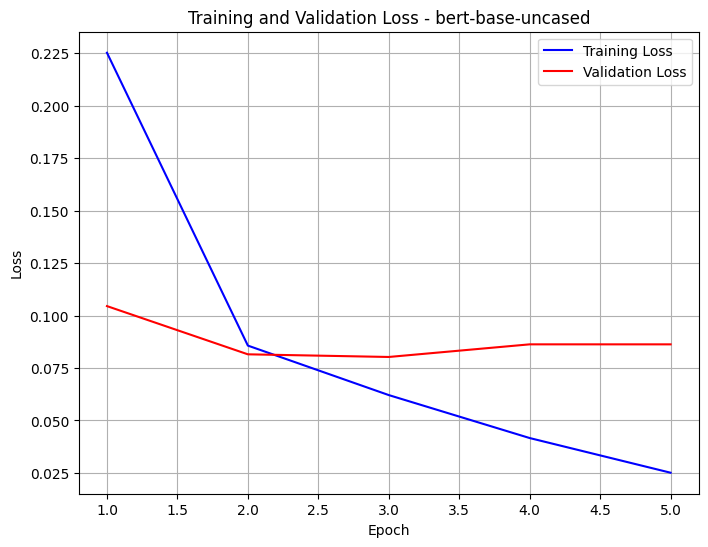

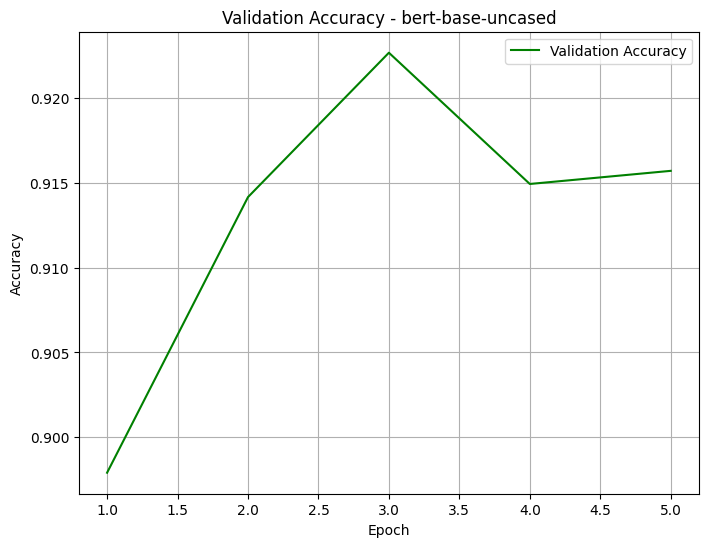

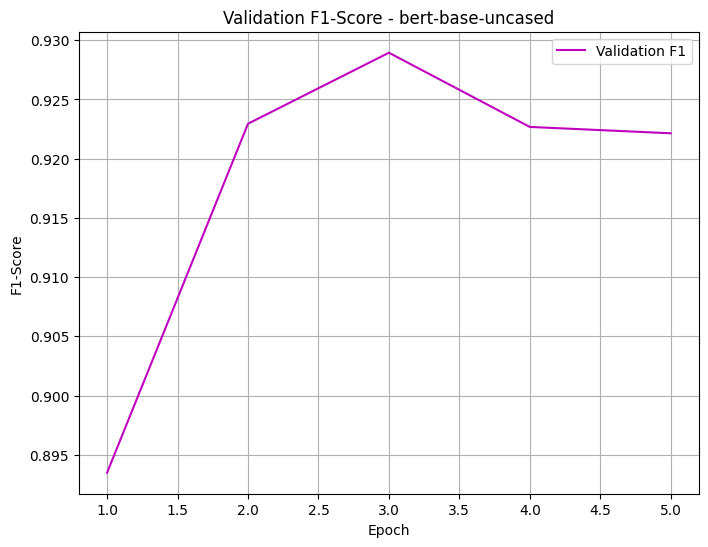

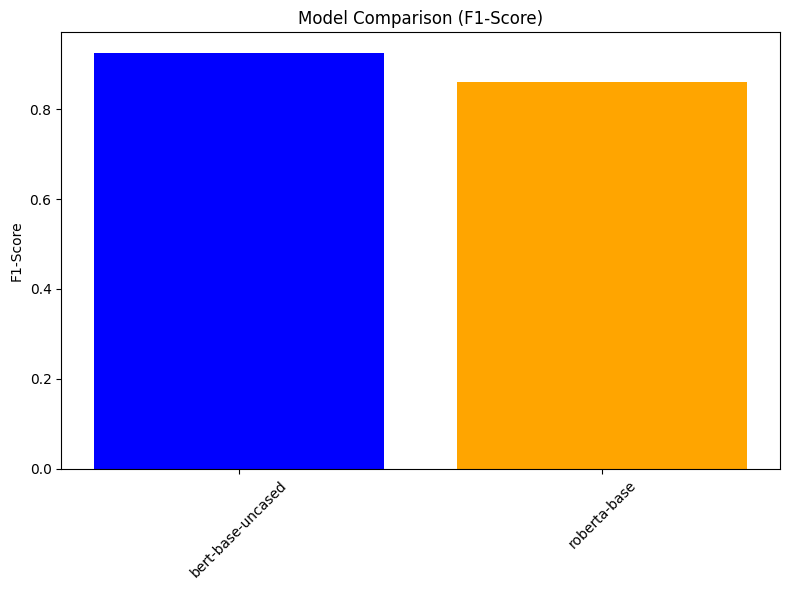


Plotting training loss from MLflow runs...


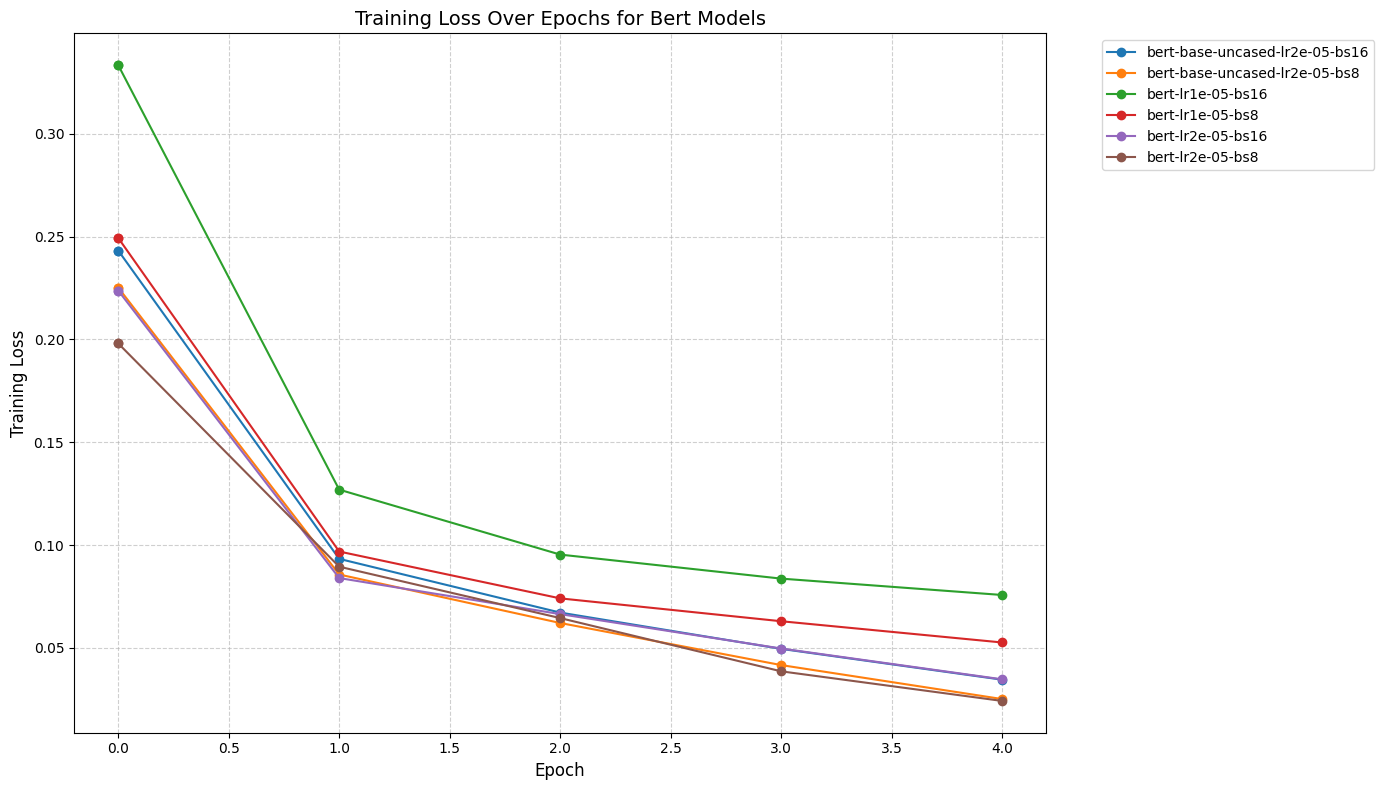

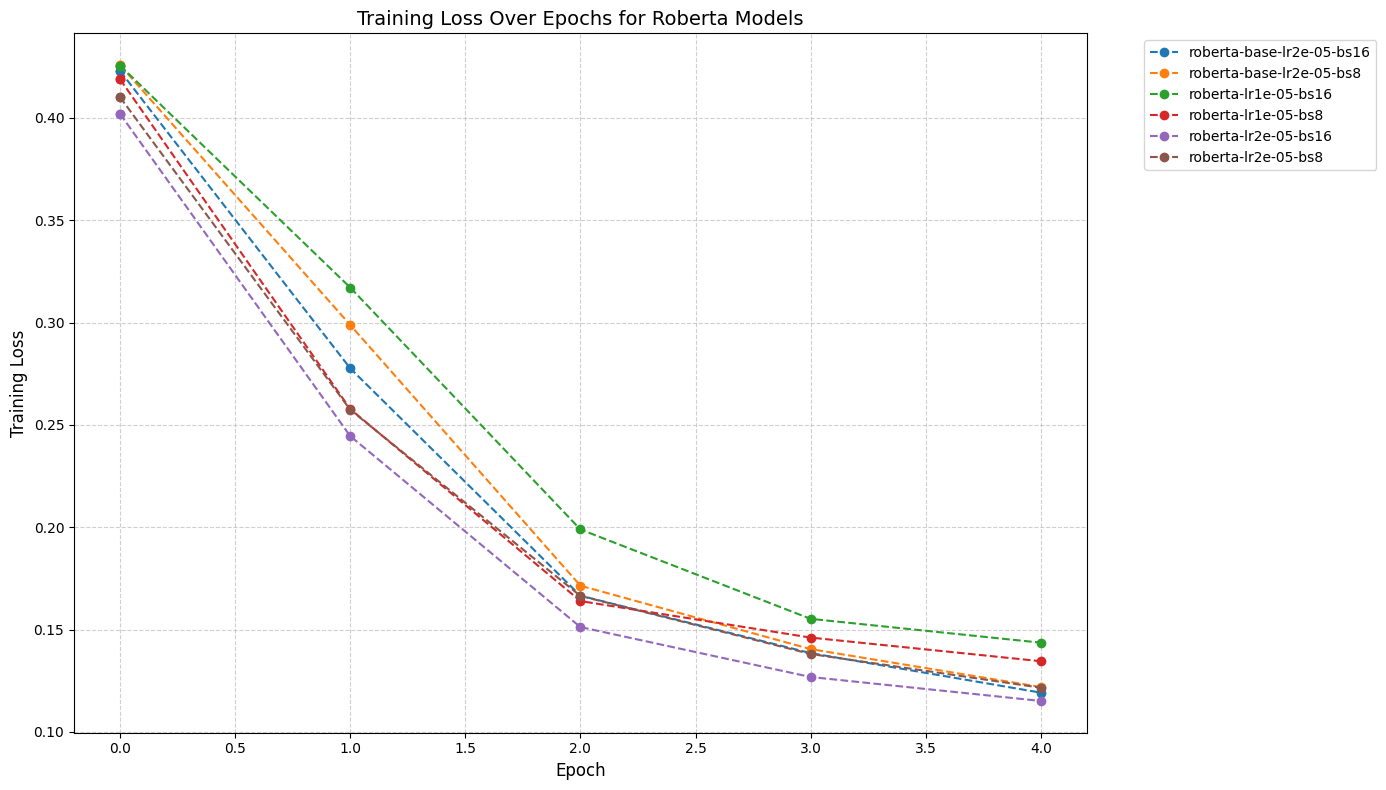

In [17]:
# Enhanced training loss plotting function
def plot_training_loss_from_mlflow(model_type):
    """Plot training loss over epochs for a specific model type from MLflow runs."""
    try:
        # Get experiment ID
        experiment = mlflow.get_experiment_by_name("/Users/j2damax@gmail.com/serendip-travel-review-classifier-experiments")
        if not experiment:
            experiment = mlflow.get_experiment_by_name("serendip-travel-experiments")

        # Fetch all runs from our experiment
        runs = mlflow.search_runs(experiment_ids=[experiment.experiment_id])
        runs_with_loss = runs[runs['tags.mlflow.runName'].notna()]

        plt.figure(figsize=(14, 8))

        # Group by run name and filter by model type
        for run_name, run_df in runs_with_loss.groupby('tags.mlflow.runName'):
            if run_name.startswith(model_type):
                # Extract metrics for this run
                run_id = run_df['run_id'].iloc[0]
                try:
                    run_metrics = mlflow.tracking.MlflowClient().get_metric_history(run_id, 'train_loss')
                except Exception as e:
                    print(f"Could not retrieve metrics for run {run_id}: {e}")
                    continue

                # Extract epochs and loss values
                epochs = [metric.step for metric in run_metrics]
                loss = [metric.value for metric in run_metrics]

                if not epochs:
                    print(f"No training loss metrics found for run {run_id}")
                    continue

                # Plot this run's training loss
                linestyle = '-' if model_type == 'bert' else '--'
                plt.plot(epochs, loss, marker='o', linestyle=linestyle, label=run_name)

        plt.title(f'Training Loss Over Epochs for {model_type.capitalize()} Models', fontsize=14)
        plt.xlabel('Epoch', fontsize=12)
        plt.ylabel('Training Loss', fontsize=12)
        plt.grid(True, linestyle='--', alpha=0.6)
        plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
        plt.tight_layout()
        plt.show()

    except Exception as e:
        print(f"Could not plot MLflow training loss: {e}")
        print("Falling back to local training curves...")


# Plot training curves for best model
history = best_result['history']
epochs = range(1, len(history['train_loss']) + 1)

# Training and validation loss plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, history['train_loss'], 'b-', label='Training Loss')
plt.plot(epochs, history['val_loss'], 'r-', label='Validation Loss')
plt.title(f'Training and Validation Loss - {best_result["config"]["model"]}')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

# Validation accuracy plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, history['val_accuracy'], 'g-', label='Validation Accuracy')
plt.title(f'Validation Accuracy - {best_result["config"]["model"]}')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Validation F1 plot
plt.figure(figsize=(8, 6))
plt.plot(epochs, history['val_f1'], 'm-', label='Validation F1')
plt.title(f'Validation F1-Score - {best_result["config"]["model"]}')
plt.xlabel('Epoch')
plt.ylabel('F1-Score')
plt.legend()
plt.grid(True)
plt.show()

# Model comparison plot
plt.figure(figsize=(8, 6))
model_names = [r['config']['model'] for r in results]
f1_scores = [r['metrics']['f1'] for r in results]
plt.bar(model_names, f1_scores, color=['blue', 'blue', 'orange', 'orange'])
plt.title('Model Comparison (F1-Score)')
plt.ylabel('F1-Score')
plt.tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()


# Plot MLflow training loss if available
print("\nPlotting training loss from MLflow runs...")
plot_training_loss_from_mlflow('bert')
plot_training_loss_from_mlflow('roberta')

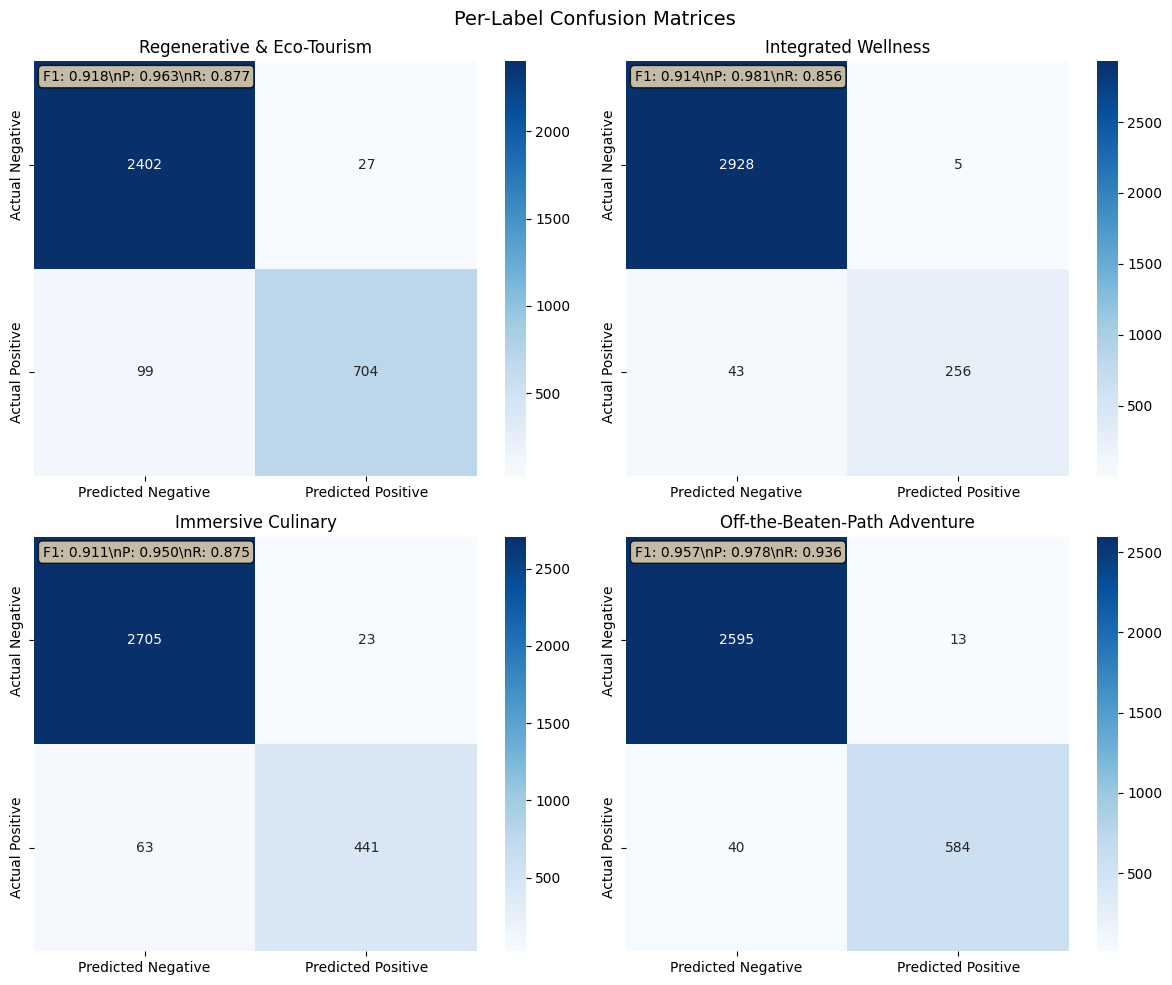

In [18]:
# Confusion matrices for best model
y_true = best_result['test_labels']
y_pred = best_result['test_predictions']

# Per-label confusion matrices
cm_matrices = multilabel_confusion_matrix(y_true, y_pred)

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
fig.suptitle('Per-Label Confusion Matrices', fontsize=14)

for i, (cm, label_name) in enumerate(zip(cm_matrices, label_names)):
    row, col = i // 2, i % 2
    ax = axes[row, col]

    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=ax,
                xticklabels=['Predicted Negative', 'Predicted Positive'],
                yticklabels=['Actual Negative', 'Actual Positive'])

    ax.set_title(label_name, fontsize=12)

    # Add metrics
    tn, fp, fn, tp = cm.ravel()
    precision = tp / (tp + fp) if (tp + fp) > 0 else 0
    recall = tp / (tp + fn) if (tp + fn) > 0 else 0
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0

    ax.text(0.02, 0.98, f'F1: {f1:.3f}\\nP: {precision:.3f}\\nR: {recall:.3f}',
            transform=ax.transAxes, fontsize=10, verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.8))

plt.tight_layout()
plt.show()


## 5. Validation and Summary


In [19]:
# Final validation and summary
print("=" * 60)
print("TRAINING AND EVALUATION SUMMARY")
print("=" * 60)

print(f"\nExperiment Results:")
print(f"  Total experiments run: {len(results)}")
print(f"  Best performing model: {best_result['config']['model']}")
print(f"  Best F1-Score: {best_result['metrics']['f1']:.4f}")
print(f"  Best Accuracy: {best_result['metrics']['accuracy']:.4f}")

print(f"\nOutput Files Generated:")
print(f"  - training_results.json: Complete experiment results")
print(f"  - test_predictions.npy: Best model predictions")
print(f"  - classification_report.json: Detailed performance metrics")

print(f"\nMLflow Integration:")
print(f"  - All experiments logged to MLflow")
print(f"  - Models saved with signatures")
print(f"  - Artifacts and metrics tracked")

print(f"\nTraining and evaluation completed successfully!")
print("=" * 60)


TRAINING AND EVALUATION SUMMARY

Experiment Results:
  Total experiments run: 4
  Best performing model: bert-base-uncased
  Best F1-Score: 0.9250
  Best Accuracy: 0.9233

Output Files Generated:
  - training_results.json: Complete experiment results
  - test_predictions.npy: Best model predictions
  - classification_report.json: Detailed performance metrics

MLflow Integration:
  - All experiments logged to MLflow
  - Models saved with signatures
  - Artifacts and metrics tracked

Training and evaluation completed successfully!


In [20]:
# Save results
results_summary = {
    'best_model': {
        'config': best_result['config'],
        'metrics': best_result['metrics']
    },
    'all_results': [
        {
            'config': r['config'],
            'metrics': r['metrics']
        }
        for r in results
    ]
}

with open('training_results.json', 'w') as f:
    json.dump(results_summary, f, indent=2)

print("Results saved to training_results.json")
print("Training and evaluation completed successfully")


Results saved to training_results.json
Training and evaluation completed successfully
